In [300]:
import os
import glob
import shutil
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.inspection import permutation_importance
from skopt import gp_minimize
from skopt.space import Real, Integer
from skopt.utils import use_named_args
from bayes_opt import BayesianOptimization
from tensorflow.keras import layers, regularizers
import tensorflow as tf

# Step 0: Data Collection
**Choosing Accounts**

When choosing the social media accounts to use the data from, it is very important that you choose accounts for which the content is mostly original music promotional videos (above 95 percent).

**Tokbackup**

Once you have selected your accounts, use Tokbackup to download their analytics data.

In [301]:
# specify the project root path, teh date the data was collected, and the number of days back from the date the data was collected that you would like to include
root_directory_path = "G:\Other computers\My Laptop\Projects & Photos\Jupyter Notebooks\TikTok Music Promotion Recommender 3"   #### CHANGE THIS
days_back = 400 #### CHANGE THIS
data_collected_date = datetime(2024, 8, 2) #### CHANGE THIS

# create variables to hold the paths of the main folders in this project
new_raw_data_path = root_directory_path + "\\New Raw Data"
old_raw_data_path = root_directory_path + "\\Old Raw Data"

# Step 1: Preprocessing
**Data Cleaning**
* This code removes rows of data that have a value of zero for variables that should be positive. For example, some of the video durations are 0 when in fact the video is more than 0 seconds long. So, I removed all rows with 0 for video duration.
* This code removes any rows that contain non-numeric values for columns that should be numbers.
* This code also removes data more than 400 days old because very old data is less reliable as the algorithm changes, and the culture around TikTok changes.
* This code applies the value of total followers for a given user data to every row in that user data file

**Feature Engineering (initially included featurs are marked with "*" and the target variable is marked with "!")**
* Features given
    * date / time uploaded
    * video views
    * comments
    * likes
    * video caption / description
    * video duration
    * video transcript / subtitles
    * shares
    * bookmarks / saves
    * sound link
    * video id
    * date backed up
    * *total followers
    * total likes
    * total views
    * total comments
    * total shares
    * total bookmarks / saves
    * total videos posted
* Features engineered
    * !Log of views
    * *number of hashtags
    * *number of generiuc hashtags
    * *number of uniwue hashtags
    * *unique generic ratio
    * *caption length
    * *number of days since cutoff date
    * *time posted
    * date posted

**Data Organization**

For the organization of data, put the raw data files from Tokbackup in the folder from the project root path called "New Raw Data." When the code processes that file of data, it will move the file to another folder in the same directory called "Old Raw Data" and will append the processed data to another data file that resides in the project root directory called "master_data_file." This file holds the data that will be used throughout this project.

In [302]:
# create master data frame
master_df = pd.DataFrame()


# Iterate through the Excel files in the "New Raw Data" folder
for filename in os.listdir(new_raw_data_path):
    if filename.endswith(".xlsx"):
        file_path = os.path.join(new_raw_data_path, filename)
        df = pd.read_excel(file_path)
    else:
        continue

    # Remove rows that contain empty cells in the video id or video file path column
    df = df.dropna(subset=['video id'])
    df = df[(df['video id'] != '')]

    # Remove the commas from the video views, comments, likes, shares, bookmarks / saves, and total followers columns
    columns_to_clean = ['video views', 'comments', 'likes', 'shares', 'bookmarks / saves', 'total followers']
    for column in columns_to_clean:
        df[column] = pd.to_numeric(df[column].astype(str).str.replace(',', ''), errors='coerce')

    # Apply the number in first row to every row for the "total followers" column
    if 'total followers' in df.columns:
        total_followers_value = df.loc[0, 'total followers']
        if not pd.isna(total_followers_value):
            df['total followers'] = df['total followers'].apply(lambda x: total_followers_value if pd.isna(x) else x)
    else:
        raise ValueError("Error: 'total followers' column not found in DataFrame")

    # Remove un-needed columns
    columns_to_remove = [
        'date backed up', 'total likes', 'total views', 
        'total comments', 'total shares', 'total bookmarks / saves', 'total videos posted', 'video transcript / subtitles'
    ]
    df.drop(columns=columns_to_remove, inplace=True)

    # Engineer the features date, time, caption length, number of hashtags
    df['date / time uploaded'] = df['date / time uploaded'].astype(str)
    df[['date posted', 'time posted']] = df['date / time uploaded'].str.split(' ', expand=True)
    df['caption length'] = df['video caption / description'].apply(lambda x: len(str(x).split('#')[0].strip()))
    df['total hashtags'] = df['video caption / description'].apply(lambda x: str(x).count('#'))
    df = df.drop(columns=['date / time uploaded'])
    
    # Engineer features for number of generic hashtags, number of unique hashtags, and the percentage of total hashtags that are unique
    generic_hashtags = ['#music', '#songwriter', '#singersongwriter', '#newartist', '#newmusic', '#undescovered', '#fyp', '#acoustic', '#song', '#guitar', 
                        '#singing', '#fypage', '#indiemusic', '#undiscoveredartist', '#foryou', '#unreleased', '#livemusic', '#diymusic', '#original', 'originalsong']
    def count_generic_hashtags(caption, generic_hashtags):
        if pd.isna(caption):
            return 0
        hashtags = caption.lower().split()
        return sum(1 for hashtag in hashtags if hashtag in generic_hashtags)
    df['generic hashtags'] = df['video caption / description'].apply(lambda x: count_generic_hashtags(x, generic_hashtags))
    df['unique hashtags'] = df['total hashtags'] - df['generic hashtags']
    def calculate_unique_generic_ratio(row):
        if row['total hashtags'] == 0:
            return 0.5
        else:
            return row['unique hashtags'] / row['total hashtags']
    df['unique generic ratio'] = df.apply(calculate_unique_generic_ratio, axis=1)

    # Calculate likes over views
    df['likes'] = pd.to_numeric(df['likes'], errors='coerce')
    df['video views'] = pd.to_numeric(df['video views'], errors='coerce')
    df['likes'] = df['likes'].fillna(0)
    df['video views'] = df['video views'].fillna(0)
    df['likes views ratio'] = df.apply(lambda row: row['likes'] / row['video views'] if row['video views'] > 0 else 0, axis=1)

    # Convert viodeo duration to seconds, and time posted to minutes
    df['video duration'] = df['video duration'].apply(lambda x: int(x.split(':')[0]) * 60 + int(x.split(':')[1]) if isinstance(x, str) else None)   
    df['time posted'] = df['time posted'].apply(lambda x: int(x.split(':')[0]) * 60 + int(x.split(':')[1]) if isinstance(x, str) else None)

    # Create the log-transformed column for video views
    df['log video views'] = np.log1p(df['video views'])

    # Remove rows where 'video duration' is zero
    df = df[df['video duration'] != 0]

    # Filter out rows where the 'date posted' is older than one year before data was collected 
    # and create 'days since start' column to hold the number of days since the cutoff date
    df['date posted'] = pd.to_datetime(df['date posted'])
    cutoff_date = data_collected_date - timedelta(days=days_back)
    df = df[df['date posted'] > cutoff_date] 
    start_date = df['date posted'].min()
    df['days since start'] = (df['date posted'] - start_date).dt.days
    
    # Add this data to the master data frame
    master_df = pd.concat([master_df, df], ignore_index=True)

    # Move the processed file to the "Old Raw Data" folder
    # old_file_path = os.path.join(old_raw_data_path, filename)
    # shutil.move(file_path, old_file_path)
    # print(f"Moved file: {filename} to Old Raw Data")



# Save the master_df to the master data file CSV in the root project directory
master_csv_file_path = os.path.join(root_directory_path, "master_data_file.csv")
if os.path.isfile(master_csv_file_path):
    master_df.to_csv(master_csv_file_path, mode='a', header=False, index=False)
else:
    master_df.to_csv(master_csv_file_path, index=False)


# delete duplicates from master data fle csv, and print a message if any are found
master_df = pd.read_csv(master_csv_file_path)
duplicates = master_df[master_df.duplicated(subset='video id', keep=False)]
if not duplicates.empty:
    print("Duplicates found:")
    # print(duplicates)
    master_df = master_df.drop_duplicates(subset='video id', keep='first')
else:
    print("No duplicates found.")

master_df.to_csv(master_csv_file_path, index=False)




Duplicates found:


# Step 2 Exploratory Data Analysis & Feature Selection

### Step 2.a: Model Selection
**Testing Potential Models**

I tested a RandomForest, LinearRegression, SVR, MLPRegressor, and 2 Neural Network architectures with default parameters to determine which model I should consider when choosing features. I did not optimize hyperparameters for these as the goal of this project is not to create a highly accurate predictive algorithm.

**Model Selection With Cross-Validated R-Squared**

I used cross-validated R-squared to determine which model to move forward with and then tested that model on the test set to ensure it generalizes well to unseen data.

In [303]:
# Define the root directory and master CSV file path
root_directory_path = "G:\\Other computers\\My Laptop\\Projects & Photos\\Jupyter Notebooks\\TikTok Music Promotion Recommender 3"
master_csv_file_path = os.path.join(root_directory_path, "master_data_file.csv")

# Load your data
data = pd.read_csv(master_csv_file_path)

# Print column names to check for typos and exact matches
# print("DataFrame Columns:")
# print(data.columns)

# Get features and target
features = ['video duration', 'caption length', 'total hashtags', 'generic hashtags', 'likes views ratio'
           , 'unique hashtags', 'unique generic ratio', 'total followers', 'time posted', 'days since start']

features = ['video duration', 'caption length', 'total hashtags', 'generic hashtags'
           , 'unique hashtags', 'unique generic ratio', 'time posted']
target = 'log video views'

# Define the features (X) and target (y)
X = data[features]
y = data[target]

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)




# Define TF models with regularization
def create_tf_linear_model(input_shape):
    model = tf.keras.Sequential([
        layers.Dense(1, input_shape=(input_shape,))
    ])
    return model

def create_tf_nn_model_1(input_shape):
    model = tf.keras.Sequential([
        layers.Dense(64, activation='relu', input_shape=(input_shape,),
                     kernel_regularizer=regularizers.l2(0.7)),
        layers.Dropout(0.5),
        layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.7)),
        layers.Dense(1)
    ])
    return model

def create_tf_nn_model_2(input_shape):
    model = tf.keras.Sequential([
        layers.Dense(128, activation='relu', input_shape=(input_shape,),
                     kernel_regularizer=regularizers.l2(0.7)),
        layers.Dropout(0.5),
        layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.7)),
        layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.7)),
        layers.Dense(1)
    ])
    return model

# Wrap TF models
class TFModelWrapper(BaseEstimator, RegressorMixin):
    def __init__(self, model_fn, epochs=100, batch_size=32):
        self.model_fn = model_fn
        self.epochs = epochs
        self.batch_size = batch_size
        self.model = None

    def fit(self, X, y):
        self.model = self.model_fn(X.shape[1])
        self.model.compile(optimizer='adam', loss='mse')
        self.model.fit(X, y, epochs=self.epochs, batch_size=self.batch_size, verbose=0)

    def predict(self, X):
        return self.model.predict(X).flatten()

    def score(self, X, y):
        y_pred = self.predict(X)
        return r2_score(y, y_pred)




# Test all models (tf and other) and choose the best one
# Define models
models = {
    'RandomForest': RandomForestRegressor(),
    'LinearRegression': LinearRegression(),
    'SVR': SVR(),
    'MLPRegressor': MLPRegressor(max_iter=1000),
    'TensorFlowLinear': TFModelWrapper(create_tf_linear_model),
    'TensorFlowNN1': TFModelWrapper(create_tf_nn_model_1),
    'TensorFlowNN2': TFModelWrapper(create_tf_nn_model_2)
}

# Train and evaluate models using cross-validation
best_model_name = None
best_score = -float('inf')

for model_name, model in models.items():
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='r2')
    mean_score = scores.mean()
    print(f'{model_name} R-squared: {mean_score:.4f}')
    if mean_score > best_score:
        best_score = mean_score
        best_model_name = model_name

print(f'Best model: {best_model_name} with R-squared: {best_score:.4f}')

# Continue with the best performing model
best_model = models[best_model_name]
best_model.fit(X_train, y_train)

# Evaluate the best model on the test set
y_pred = best_model.predict(X_test)
test_r2 = r2_score(y_test, y_pred)
print(f'Test R-squared for {best_model_name}: {test_r2:.4f}')

RandomForest R-squared: 0.2908
LinearRegression R-squared: 0.1139
SVR R-squared: 0.0725
MLPRegressor R-squared: 0.0368
18/18 [==============================] - 0s 530us/step
TensorFlowLinear R-squared: -1.6531
18/18 [==============================] - 0s 648us/step
TensorFlowNN1 R-squared: -0.0690
18/18 [==============================] - 0s 706us/step
TensorFlowNN2 R-squared: -0.1118
Best model: RandomForest with R-squared: 0.2908
Test R-squared for RandomForest: 0.3523


### Step 2.b: Feature Selection
**Feature Importance Analysis**

I utilized the Mean Decrease in Impurity method to determine the relative importance of the included features.

**Feature Selection**

The code cell below creates a small user interface in the output of the cell where you can add and remove features to see how that changes the relative importance of other features, as well as the cross-validated R-squared of the model. I used my domain knowledge and the insights from the changes in the relative importance ratings and R-squared to decide on the final set of features to be included in the recommendation system.

DataFrame Columns:
Index(['tiktok link', 'video views', 'comments', 'likes',
       'video caption / description', 'video duration', 'shares',
       'bookmarks / saves', 'sound link', 'video id', 'total followers',
       'date posted', 'time posted', 'caption length', 'total hashtags',
       'generic hashtags', 'unique hashtags', 'unique generic ratio',
       'likes views ratio', 'log video views', 'days since start'],
      dtype='object')
Initial evaluation with all features:
RandomForest R-squared (cross-validated): 0.4070


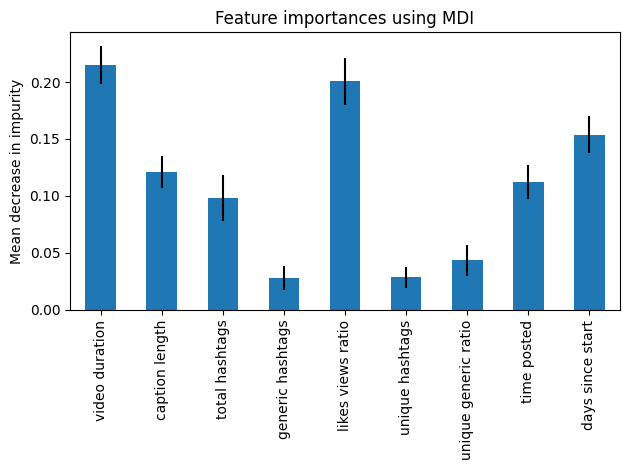


Current features: ['video duration', 'caption length', 'total hashtags', 'generic hashtags', 'likes views ratio', 'unique hashtags', 'unique generic ratio', 'time posted', 'days since start']


Enter 'add' to add a feature, 'remove' to remove a feature, or 'done' to finish:  done


In [304]:
# Define the root directory and master CSV file path
root_directory_path = "G:\\Other computers\\My Laptop\\Projects & Photos\\Jupyter Notebooks\\TikTok Music Promotion Recommender 3"
master_csv_file_path = os.path.join(root_directory_path, "master_data_file.csv")

# Load your data
data = pd.read_csv(master_csv_file_path)

# Print column names to check for typos and exact matches
print("DataFrame Columns:")
print(data.columns)

# Define the initial set of features and target
initial_features = ['video duration', 'caption length', 'total hashtags', 'generic hashtags', 'likes views ratio',
                    'unique hashtags', 'unique generic ratio', 'time posted', 'days since start']
target = 'log video views'

# Split the data into training and test sets
X = data[initial_features]
y = data[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Function to train and evaluate model, and plot feature importance using cross-validation
def train_evaluate_model_cv(selected_features):
    # Define the features (X) and target (y)
    X_selected = X_train[selected_features]
    y_selected = y_train

    # Scale features
    scaler = StandardScaler()
    X_selected = scaler.fit_transform(X_selected)

    # Train Random Forest model
    rf = RandomForestRegressor(random_state=42)
    rf.fit(X_selected, y_selected)

    # Evaluate model with cross-validation
    cv_scores = cross_val_score(rf, X_selected, y_selected, cv=5, scoring='r2')
    print(f'RandomForest R-squared (cross-validated): {cv_scores.mean():.4f}')

    # Feature importance analysis
    importances = rf.feature_importances_
    std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)
    forest_importances = pd.Series(importances, index=selected_features)

    # Plot feature importances
    fig, ax = plt.subplots()
    forest_importances.plot.bar(yerr=std, ax=ax)
    ax.set_title("Feature importances using MDI")
    ax.set_ylabel("Mean decrease in impurity")
    fig.tight_layout()
    plt.show()

# Initial evaluation with all features
print("Initial evaluation with all features:")
train_evaluate_model_cv(initial_features)

# Interactive feature selection loop
def interactive_feature_selection():
    current_features = initial_features.copy()
    while True:
        print("\nCurrent features:", current_features)
        action = input("Enter 'add' to add a feature, 'remove' to remove a feature, or 'done' to finish: ").strip().lower()
        if action == 'add':
            feature_to_add = input("Enter the feature to add: ").strip()
            if feature_to_add in data.columns and feature_to_add not in current_features:
                current_features.append(feature_to_add)
                print(f"Added feature: {feature_to_add}")
            else:
                print(f"Feature {feature_to_add} is not valid or already included.")
        elif action == 'remove':
            feature_to_remove = input("Enter the feature to remove: ").strip()
            if feature_to_remove in current_features:
                current_features.remove(feature_to_remove)
                print(f"Removed feature: {feature_to_remove}")
            else:
                print(f"Feature {feature_to_remove} is not in the current feature set.")
        elif action == 'done':
            break
        else:
            print("Invalid action. Please enter 'add', 'remove', or 'done'.")
        # Re-evaluate model with updated features
        train_evaluate_model_cv(current_features)

# Start interactive feature selection
interactive_feature_selection()

In [305]:
# Define the final set of features
final_features = ['video duration', 'caption length', 'total hashtags', 'generic hashtags', 'unique hashtags', 'time posted']

# Select and scale features
X_train_final = X_train[final_features]
X_test_final = X_test[final_features]

scaler = StandardScaler()
X_train_final = scaler.fit_transform(X_train_final)
X_test_final = scaler.transform(X_test_final)

# Train the final Random Forest model
rf_final = RandomForestRegressor(random_state=42)
rf_final.fit(X_train_final, y_train)

# Evaluate on the test set
y_pred_final = rf_final.predict(X_test_final)
test_r2_final = r2_score(y_test, y_pred_final)
print(f'Final Test R-squared: {test_r2_final:.4f}')

Final Test R-squared: 0.3384


# Train Optimization

I utilized Bayesian Optimization to determine the optimal value for the included parameters to maximize my target variable. Bayesian Optimization helps efficiently explore the parameter space and find the best combination of feature values by balancing exploration and exploitation.

In [306]:
# Define the root directory and master CSV file path
root_directory_path = "G:\\Other computers\\My Laptop\\Projects & Photos\\Jupyter Notebooks\\TikTok Music Promotion Recommender 3"
master_csv_file_path = os.path.join(root_directory_path, "master_data_file.csv")

# Load the data from the CSV file
data = pd.read_csv(master_csv_file_path)

# Define the features and target variable
features = ['video duration', 'caption length', 'total hashtags', 'generic hashtags', 'unique hashtags', 'time posted']
target = 'log video views'

# Define the search space for the features
search_space = [
    Real(data['video duration'].min(), data['video duration'].max(), name='video duration'),
    Real(data['caption length'].min(), data['caption length'].max(), name='caption length'),
    Real(data['total hashtags'].min(), data['total hashtags'].max(), name='total hashtags'),
    Real(data['generic hashtags'].min(), data['generic hashtags'].max(), name='generic hashtags'),
    Real(data['unique hashtags'].min(), data['unique hashtags'].max(), name='unique hashtags'),
    Real(data['time posted'].min(), data['time posted'].max(), name='time posted')
]

# Define the objective function
@use_named_args(search_space)
def objective(**params):
    # Create a single sample dataframe with the parameter values
    sample_df = pd.DataFrame([params])
    
    # Find the closest match in the dataset (nearest neighbor)
    closest_match = data.iloc[((data[features] - sample_df.values) ** 2).sum(axis=1).idxmin()]
    
    # Return the negative log video views (since gp_minimize performs minimization)
    return -closest_match[target]

# Perform Bayesian optimization with a starting number of calls
initial_n_calls = 30
res = gp_minimize(objective, search_space, n_calls=initial_n_calls, random_state=42)

# Print initial function values
print("Initial function values:", res.func_vals)

# Check for convergence
convergence_threshold = 0.01  # Define a small threshold for convergence
max_no_improvement_iterations = 10  # Define the maximum number of iterations with no significant improvement

no_improvement_counter = 0
improvement = float('inf')

while no_improvement_counter < max_no_improvement_iterations:
    additional_n_calls = 10
    previous_best = res.fun
    res = gp_minimize(objective, search_space, n_calls=additional_n_calls, x0=res.x_iters, y0=res.func_vals, random_state=42)
    current_best = res.fun
    
    improvement = abs(previous_best - current_best)
    if improvement < convergence_threshold:
        no_improvement_counter += 1
    else:
        no_improvement_counter = 0

    # print(f"Improvement: {improvement}, Objective Function Value: {current_best}, Total calls: {len(res.func_vals)}, No improvement count: {no_improvement_counter}")
    # print("Function values:", res.func_vals)

# Extract the optimal feature values
optimal_values = res.x
optimal_params = {name: value for name, value in zip(features, optimal_values)}
print("Optimal feature values:", optimal_params)

# Evaluate the optimal feature values
sample_df = pd.DataFrame([optimal_params])
closest_match = data.iloc[((data[features] - sample_df.values) ** 2).sum(axis=1).idxmin()]
optimal_log_video_views = closest_match[target]
print(f'Optimal predicted log video views: {optimal_log_video_views}')

Initial function values: [-11.78904849  -6.97914528 -11.79961454  -6.79794041  -8.66475076
  -6.79794041  -5.81711116  -9.56106766 -12.7696833  -10.91510665
  -5.95583737 -11.0540754   -5.95583737 -12.7696833  -12.7696833
  -8.8545222   -7.71601527 -13.3645265   -7.56060116  -6.70686234
  -6.77422389 -13.3645265   -9.89852526 -12.25914411  -6.70686234
 -13.3645265  -13.3645265   -9.18819701 -13.3645265  -13.3645265 ]
Optimal feature values: {'video duration': 86.02093863859503, 'caption length': 39.392341318247745, 'total hashtags': 21.85352279720435, 'generic hashtags': 2.0188800224662162, 'unique hashtags': 9.031850627774837, 'time posted': 1303.1601047267802}
Optimal predicted log video views: 13.36452650441178
